# Using Quantum circuits to generate and manipulate wavetables on SuperCollider
## Part 1 : The "Dithering" and the "Geiger Counter" Effects

This example is a simple application of a quantum audio representation. Wavetable synthesis is a good option for the near-term quantum technology, since it requires a small audio sample, containing just one period of a desired oscillattor.

The main idea is to:
+ Create a wavetable in python
+ Create a quantum circuit that prepares a quantum audio state from the table using a quantum audio encoding scheme - and measure it back.
+ Use a [SuperCollider](https://supercollider.github.io/) (SC) server as a wavetable synthesis engine
+ Load the wavetable into SuperCollider and start listening to the synthesizer
+ Simulate the quantum circuit several times and update the wavetable with the results in real time


For creating the quantum audio state we will use the IBM's *Qiskit* language/framework and the *quantumaudio* module for building the quantum audio circuits. For more information on how to use the *quantumaudio.py* module, refer to the [*Quantum Audio Module Demo*](https://github.com/iccmr-quantum/quantumaudio/blob/main/Quantum%20Audio%20Module.ipynb).

#### This Notebook is suposed to be run along with a SuperCollider server (scsynth or supernova), contatining a pre-defined or a pre-stored wavetable SynthDef called "\qTable", like the one declared in the example file *Wavetables.scd*. 
#### If you have a SuperCollider client (like SCIDE, SCApp, etc), you can open the Wavetables.scd script.  Boot the server by positioning the cursor at the "s.boot;" line and then pressing  "  Ctrl(Cmd)+Enter ". Then store (and load) the \qtable SynthDef, by positioning the cursor at any line inside the definition and pressing"  Ctrl(Cmd)+Enter ".

<!-- #### For a more detailed step-by-step guide about the SuperCollider side, as well as a CLI only setup, refer to the README.md file that can be read on the [Github Page](https://github.com/iccmr-quantum) <> -->

Python dependencies: 

First, make sure you have all of the following dependencies installed:
- quantumaudio
- numpy
- matplotlib
- IPython.display
- bitstring
- qiskit
- liblo
- [python-supercollider client ](https://pypi.org/project/supercollider/)

Import everything:

In [1]:
import numpy as np
from numpy import pi
import time
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

Now we will create a wavetable with one period of a sine function. The table will have 64 samples, which will produce a 6-qubit QPAM audio state:

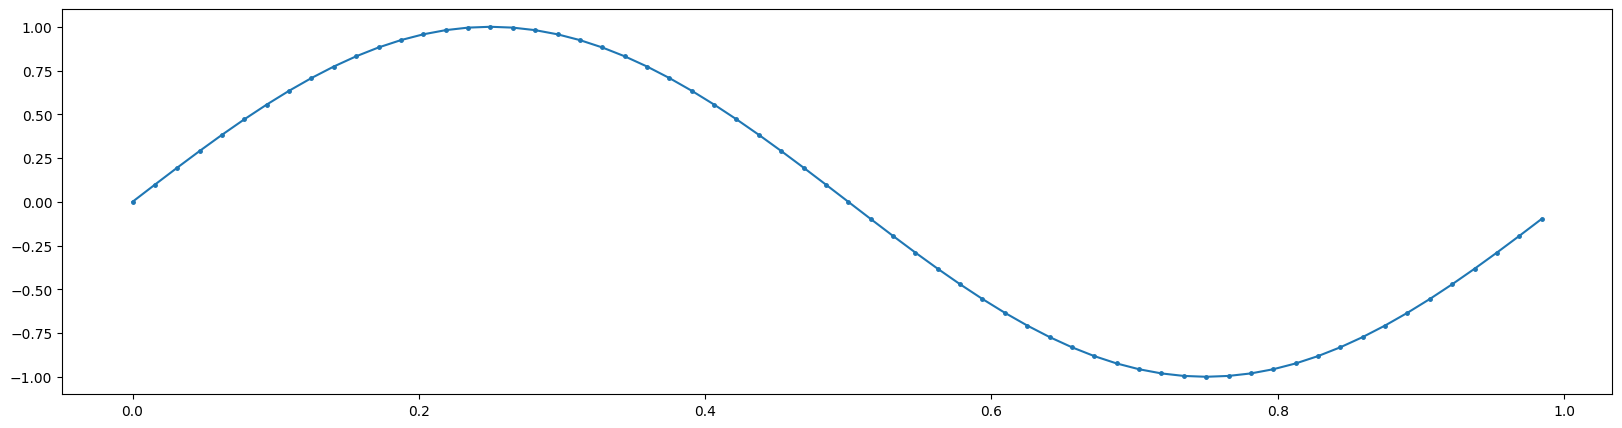

In [2]:
# Audio Sample / Table
qubit_size = 6
table_size = 2**qubit_size
t = np.linspace(0, 1-1/table_size, table_size)
sinewave = np.sin(2*np.pi*t)
plt.figure(figsize=(20,5))
plt.plot(t, sinewave, '.-', ms=5)
plt.show()

### Stablishing a connection with SuperCollider

SuperCollider is a musical platform with a server-client structure. The server side is a powerful synthesis engine, *scsynth*, similar to what can be found in game development environments like *Unreal Engine*. The client side is an interpreted programming language with a javascript-like sintax, *sclang*. The language is used to send real-time messages to the synthesis engine using the OSC (Open Sound Control) communication protocol. Client messages could be instructions to create/instantiate synth nodes according to some definition, allocate buffers, change synth parameters, run a complex synthesis routine, etc.

Due to this structure, many projects have been able to wrap *sclang* messages in other programming languages, like Python. One very successful python-based Supercollider client app & IDE is called [FoxDot](https://foxdot.org/). But since we wish to communicate with SC from a Jupyter Notebook, we will use a more minimalistic approach, with the [*python-supercollider module*](https://pypi.org/project/supercollider/). It has a minimal set of objects from *sclang* (Sever, Buffer, Synth, Group, Bus), that can act as a SC client, building OSC messages and sending them directly to *scsynth*.

In [3]:
from supercollider import Server, Buffer, Synth

Let's connect to a running *scsynth*:
##### (Note: *you need to boot your SuperCollider server before this step*)

In [4]:
server = Server()

SuperCollider has a special way of dealing with wavetables. The wavetable buffers are written in a specific [*supercollider wavetable format*](https://depts.washington.edu/dxscdoc/Help/Classes/Wavetable.html#inheritedinstmets), which are optimized in a way that requires less runtime operations. Any UGen that deals with wavetables (like the 'Osc' UGen in the *Wavetables.scd* file) will expect to read a buffer in this format. 
This buffer is twice the size of the original table and its content stores a pre-processed version of the wavetable. The following function handles this buffer pre-processing, according to specification: 

In [5]:
def toWavetable(signal):
    wavetable = np.zeros(2*len(signal))
    wavetable[0::2] = 2*signal - np.roll(signal, -1)
    wavetable[1::2] = np.roll(signal, -1) - signal
    return wavetable

The next function will be used to update an allocated buffer in SuperCollider, using the SC 'set' message:

In [6]:
def updateBuffer (buffer, signal):
    wavetableformat = toWavetable(signal)
    buffer.set(wavetableformat)

Let's try to listen to 1 second of our sinewave on SC. 
First we need to allocate a buffer, and update it with our wavetable:

In [7]:
b = Buffer.alloc(server, 2*len(sinewave))

In [8]:
wavetable = sinewave
updateBuffer(b, wavetable)

Let's synth! 

The following code will instantiate a Synth node in SC and play it. Then it waits for 1 second, and sends a 'free' message to the server, releasing the instance. Notice how you can set SynthDef keyword arguments using a dictionary in the third positional argument of the Synth function: 

**Be Careful with your sound speaker/headphone volume! The default gain is set to -25dB in the line below, which is audible in many systems. Tune up the gain as necessary.**

In [9]:
synth = Synth(server, "qTable", {"buf" : b, "gain" : -25, "freq" : 350})
time.sleep(1)
synth.free()

So far, so good! You should have listened to a sinusoidal oscillator created in python and numpy sine function! Now, let's use quantum computing to manipulate this table.

### Quantum ""Dithering""

First, let's explore a simple quantum circuit example. We will just prepare a QPAM quantum audio circuit from the sine table using the QuantumAudio class inside the *quantumaudio.py* module (refer to the *Quantum Audio Module Demo* to learn more), then apply measurements imediatelly after the preparation - a *"quantum audio loopback"*.



In [10]:
import quantumaudio as qa

In [11]:
qsine = qa.QuantumAudio('qpam').load_input(sinewave)

For this input, the QPAM representation will require:
         6 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.


This simple loopback circuit can already lead to some interesting artirtic sounding reults - if we use QPAM's inherently *imperfect, probabilistic retrieval* characteristics wisely.  

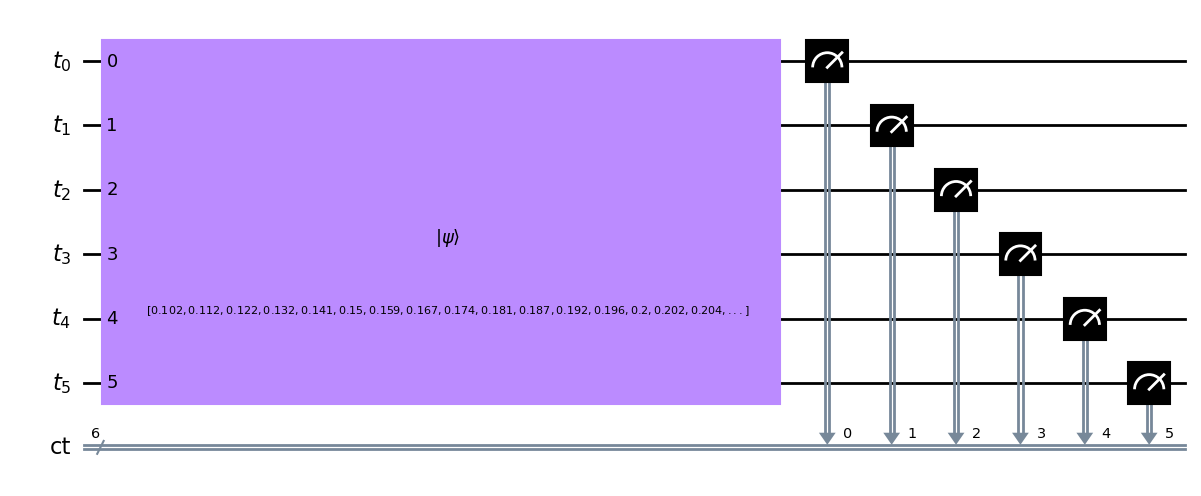

In [12]:
qsine.prepare().measure()
qsine.circuit.draw('mpl')

Now that everything is set up, and we can run (or simulate in this case) the circuit and then use the results to update the wavetable:

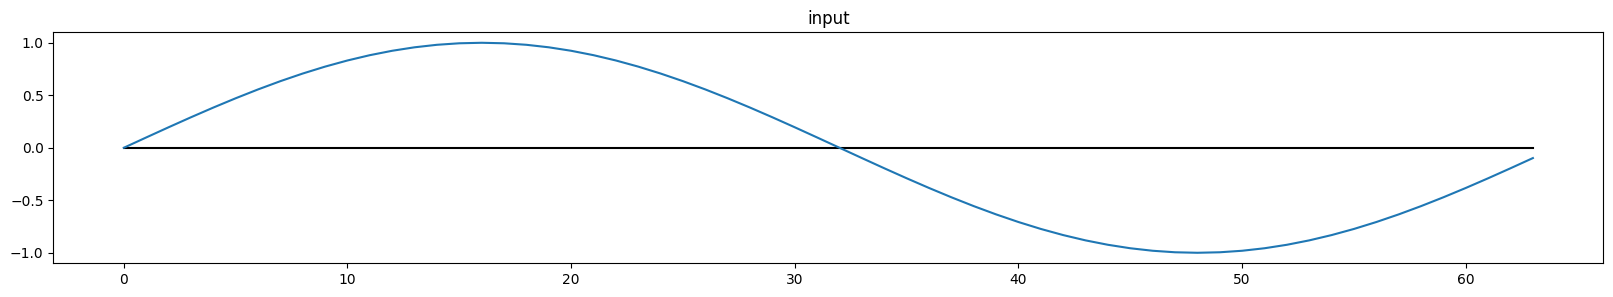

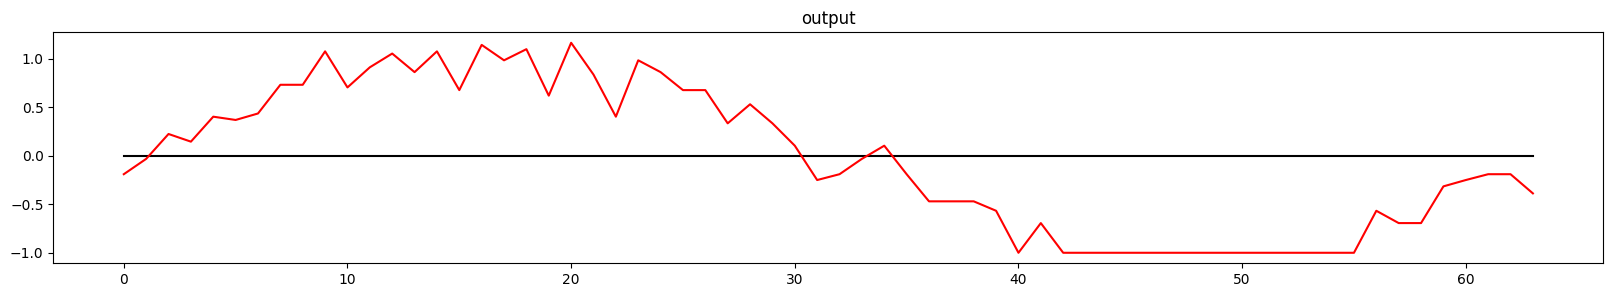

In [13]:
shots = 1024
wavetable = qsine.run(shots).reconstruct_audio().output
qsine.plot_audio()

Start the synth again,

In [14]:
synth = Synth(server, "qTable", {"buf" : b, "gain" : -35, "freq" : 350})

and update the buffer:

In [15]:
updateBuffer(b, wavetable)

Voila!! You can notice that the sound is not perfectly reconstructed, due to the small number of shots. The result is the introduction of some noise on the signal. This is referred as a *Quantum Dithering Effect*. The higher the number of shots, the lower is the noise amplitude.

For stopping the synth, run:

In [16]:
synth.free()

### Wavetable Update Loops and the Geiger Counter Effect
An immediate extension of this buffer updating idea is to simulate the circuit seversal times, changing the number of shots on each run while listening to the variations in real time. 

Let's start our synth again, with our original signal:

In [17]:
updateBuffer(b, sinewave)
synth = Synth(server, "qTable", {"buf" : b, "gain" : -35, "freq" : 250})

Then we will make a loop and run the circuit several times. The effect will be a 'colour' change in the sound timbre. (fell free to experiment with different parameters):

In [18]:
SHOTS =[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 100000]

In [19]:
time_interval = 0.1
for i in SHOTS:
    wavetable = qsine.run(i).reconstruct_audio().output
    updateBuffer(b, wavetable)
    time.sleep(time_interval)

In [20]:
synth.free()

But depending on the choice of wavetable & parameters, with a slow reading frequency (~1Hz), the auditory result reminds the sound of a *Geiger Counter*, a physics measuring device used to detect radiation particles.
Let's build a geiger counter example with a 10-qubit (1024 samples) wavetable with a 100Hz sinewave:

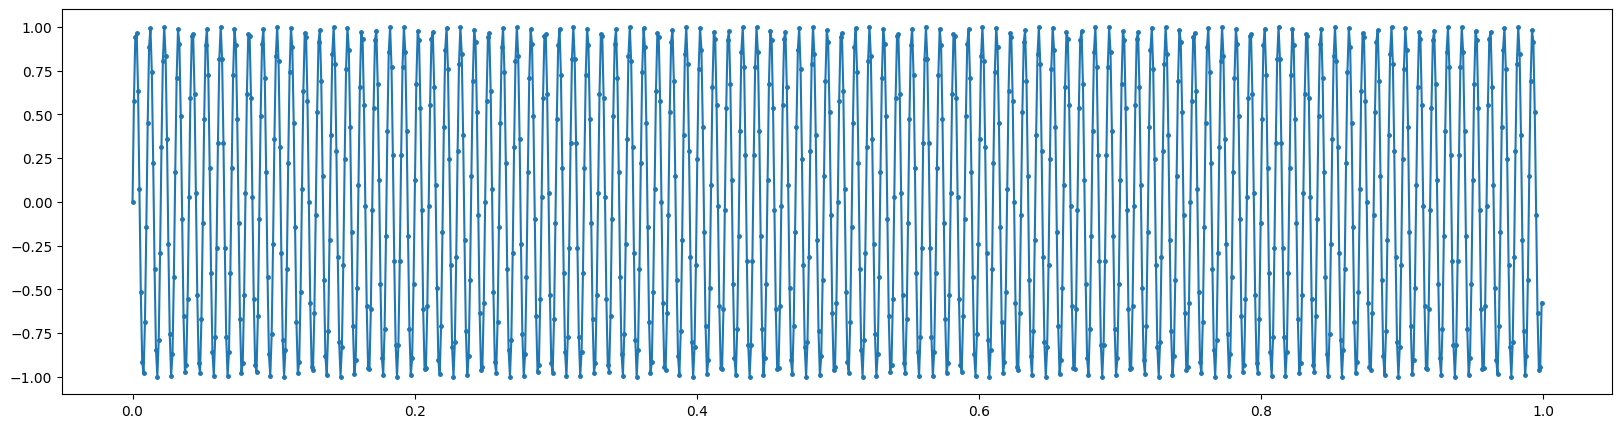

In [21]:
# Audio Sample / Table
qubit_size = 10
size = 2**qubit_size
t = np.linspace(0, 1-1/size, size)
geiger = np.sin(2*np.pi*100*t)
plt.figure(figsize=(20,5))
plt.plot(t, geiger, '.-', ms=5)
plt.show()

In [22]:
qgeiger = qa.QuantumAudio('qpam').load_input(geiger).prepare().measure()

For this input, the QPAM representation will require:
         10 qubits for encoding time information and 
         0 qubits for encoding ampĺitude information.


In [23]:
g = Buffer.alloc(server, 2*len(geiger))


In [24]:
updateBuffer(g, geiger)

In [25]:
synth = Synth(server, "qTable", {"buf" : g, "gain" : -22, "freq" : 1})

In [26]:
SHOTS =[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 50000, 100000]
time_interval = 1
for i in SHOTS:
    wavetable = qgeiger.run(i).reconstruct_audio().output
    updateBuffer(g, wavetable)
    time.sleep(time_interval)


In [27]:
synth.free()

At first, the circuit has too litle shots, and the distribution will peak in a few states, resulting on the sharp attacks typical of a geiger counter. As the amount of shots increases, the sound turns into noise. Then the statistical distribution slowly starts to take the form of the original table, and the original sound arises from the noise.

.

.

Itaborala @ QuTune https://github.com/iccmr-quantum/quantumaudio